In [26]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import pandas as pd
from sklearn.metrics import classification_report, accuracy_score, f1_score, roc_auc_score, precision_recall_curve, auc
import pandas as pd
import numpy as np
import torch
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from tensorflow.keras.preprocessing.sequence import pad_sequences
import re
from collections import Counter



# usual preprocessing as in 3_dataloader_and_embeddings as doing this is easier that saving dataleader and calling it here

In [ ]:
df = pd.read_csv(r"C:\Users\abhis\OneDrive\Desktop\week4\Sequence Modelling Basics\data\cleaned_sampled_train.csv")
df = df.dropna(subset=['cleaned_review'])
df = df[df['cleaned_review'].apply(lambda x: isinstance(x, str))]
df['polarity'] = df['polarity'].map({1: 0, 2: 1})
print("Unique polarity values:", df['polarity'].unique())
print("Polarity dtype:", df['polarity'].dtype)
print(df.head())
print(f"Dataset size: {len(df)}")


Unique polarity values: [0 1]
Polarity dtype: int64
                                      cleaned_review  \
0  the light bulb does not light anything, has a ...   
1  i purchased the flowtron bf 190 replacement bu...   
2  it doesn't work well in the hamilton beech sin...   
3  it took me forever to get through this book. i...   
4  this was a little of a deception, is smaller t...   

                      title  polarity  
0       PIAA SUPER LED BULB         0  
1               unsatisfied         0  
2  Refillable Coffee Filter         0  
3         Not to our liking         0  
4               Not so good         0  
Dataset size: 799998


In [ ]:
def simple_tokenizer(text):
    if isinstance(text, str):
        return text.lower().strip().split()
    return []


In [29]:
def simple_tokenizer(text):
    text = text.lower().strip()
    tokens = text.split()
    return tokens

df['tokens'] = df['cleaned_review'].apply(simple_tokenizer)

print(df['tokens'].head())


0    [the, light, bulb, does, not, light, anything,...
1    [i, purchased, the, flowtron, bf, 190, replace...
2    [it, doesn't, work, well, in, the, hamilton, b...
3    [it, took, me, forever, to, get, through, this...
4    [this, was, a, little, of, a, deception,, is, ...
Name: tokens, dtype: object


In [ ]:
from collections import Counter

all_tokens = [token for tokens in df['tokens'] for token in tokens]
token_counts = Counter(all_tokens)

vocab_size = 20000
most_common_tokens = token_counts.most_common(vocab_size - 2)

PAD_TOKEN = "<PAD>"
UNK_TOKEN = "<UNK>"

word2idx = {PAD_TOKEN: 0, UNK_TOKEN: 1}
for i, (word, _) in enumerate(most_common_tokens, start=2):
    word2idx[word] = i

print(f"Vocabulary size (including PAD & UNK): {len(word2idx)}")

def tokens_to_indices(tokens):
    return [word2idx.get(token, word2idx[UNK_TOKEN]) for token in tokens]

df['indexed_tokens'] = df['tokens'].apply(tokens_to_indices)

print(df['indexed_tokens'].head())


Vocabulary size (including PAD & UNK): 20000
0    [2, 359, 3692, 107, 16, 359, 3498, 40, 5, 1024...
1    [4, 201, 2, 1, 1, 1, 717, 3692, 19, 210, 10101...
2    [10, 160, 130, 91, 11, 2, 6605, 1, 521, 2809, ...
3    [10, 297, 58, 1814, 6, 51, 146, 8, 131, 10, 10...
4    [8, 14, 5, 101, 7, 5, 1, 9, 1122, 64, 4, 1, 39...
Name: indexed_tokens, dtype: object


In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

max_len = 150 
df['padded_tokens'] = list(pad_sequences(df['indexed_tokens'], maxlen=max_len, padding='post', truncating='post'))

print(df['padded_tokens'].head())
print(f"Padded sequences shape example: {df['padded_tokens'].iloc[0].shape}")


0    [2, 359, 3692, 107, 16, 359, 3498, 40, 5, 1024...
1    [4, 201, 2, 1, 1, 1, 717, 3692, 19, 210, 10101...
2    [10, 160, 130, 91, 11, 2, 6605, 1, 521, 2809, ...
3    [10, 297, 58, 1814, 6, 51, 146, 8, 131, 10, 10...
4    [8, 14, 5, 101, 7, 5, 1, 9, 1122, 64, 4, 1, 39...
Name: padded_tokens, dtype: object
Padded sequences shape example: (150,)


In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader

class ReviewDataset(Dataset):
    def __init__(self, texts, labels):
        self.texts = torch.tensor(np.array(texts), dtype=torch.long)
        self.labels = torch.tensor(labels.values, dtype=torch.float32)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.texts[idx], self.labels[idx]


dataset = ReviewDataset(df['padded_tokens'].tolist(), df['polarity'])
batch_size = 128
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
sample_batch = next(iter(dataloader))
print("Sample batch shapes:")
print("Texts:", sample_batch[0].shape)
print("Labels:", sample_batch[1].shape)


Sample batch shapes:
Texts: torch.Size([128, 150])
Labels: torch.Size([128])


In [33]:
from sklearn.model_selection import train_test_split
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['polarity'])

In [34]:
import torch
from torch.utils.data import Dataset, DataLoader

# Custom Dataset
class ReviewDataset(Dataset):
    def __init__(self, texts, labels):
        self.texts = torch.tensor(np.array(texts), dtype=torch.long)
        self.labels = torch.tensor(labels.values, dtype=torch.float32)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.texts[idx], self.labels[idx]

# Create datasets
train_dataset = ReviewDataset(train_df['padded_tokens'].tolist(), train_df['polarity'])
val_dataset = ReviewDataset(val_df['padded_tokens'].tolist(), val_df['polarity'])

# Create DataLoaders
batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Check a sample batch
sample_batch = next(iter(train_loader))
print("Sample batch shape (X):", sample_batch[0].shape)
print("Sample batch shape (y):", sample_batch[1].shape)


Sample batch shape (X): torch.Size([128, 150])
Sample batch shape (y): torch.Size([128])


In [35]:
class ReviewsDataset(Dataset):
    def __init__(self, reviews, labels):
        self.reviews = reviews
        self.labels = labels

    def __len__(self):
        return len(self.reviews)

    def __getitem__(self, idx):
        return torch.tensor(self.reviews[idx], dtype=torch.long), torch.tensor(self.labels[idx], dtype=torch.float)


In [36]:
class SimpleRNNModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim):
        super(SimpleRNNModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.rnn = nn.RNN(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.embedding(x)
        output, _ = self.rnn(x)
        out = output[:, -1, :]
        out = self.fc(out)
        return self.sigmoid(out).squeeze(1)


In [38]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

vocab_size = len(word2idx)
embedding_dim = 100
hidden_dim = 128

model = SimpleRNNModel(vocab_size, embedding_dim, hidden_dim).to(device)

criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [39]:
num_epochs = 5

for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    for batch_inputs, batch_labels in train_loader:
        batch_inputs, batch_labels = batch_inputs.to(device), batch_labels.to(device)

        optimizer.zero_grad()
        outputs = model(batch_inputs)
        loss = criterion(outputs, batch_labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch+1}/{num_epochs} - Loss: {avg_loss:.4f}")


Epoch 1/5 - Loss: 0.6942
Epoch 2/5 - Loss: 0.6927
Epoch 3/5 - Loss: 0.6897
Epoch 4/5 - Loss: 0.6930
Epoch 5/5 - Loss: 0.6927


In [ ]:
import matplotlib.pyplot as plt

gradient_norms = []  # for gradient plot


In [ ]:
num_epochs = 10

for epoch in range(num_epochs):
    # trainng phase
    model.train()
    train_loss = 0
    correct = 0
    total = 0
    epoch_grad_norms = [] # we gon have to reset this for each epoch
    for batch_inputs, batch_labels in train_loader:
        batch_inputs, batch_labels = batch_inputs.to(device), batch_labels.to(device)

        optimizer.zero_grad()
        outputs = model(batch_inputs)
        loss = criterion(outputs, batch_labels)
        loss.backward()

        # gradient norm tracking
        total_norm = 0.0
        for name, param in model.named_parameters():
            if param.requires_grad and "rnn" in name and param.grad is not None:
                param_norm = param.grad.data.norm(2)
                total_norm += param_norm.item() ** 2
        batch_grad_norm = total_norm ** 0.5
        epoch_grad_norms.append(batch_grad_norm)

        optimizer.step()

        train_loss += loss.item()
        predicted = (outputs >= 0.5).float()
        correct += (predicted == batch_labels).sum().item()
        total += batch_labels.size(0)

    train_acc = correct / total
    avg_train_loss = train_loss / len(train_loader)

    avg_grad_norm = sum(epoch_grad_norms) / len(epoch_grad_norms)
    gradient_norms.append(avg_grad_norm)

    # validn phase
    model.eval()
    val_loss = 0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for batch_inputs, batch_labels in val_loader:
            batch_inputs, batch_labels = batch_inputs.to(device), batch_labels.to(device)

            outputs = model(batch_inputs)
            loss = criterion(outputs, batch_labels)

            val_loss += loss.item()
            predicted = (outputs >= 0.5).float()
            val_correct += (predicted == batch_labels).sum().item()
            val_total += batch_labels.size(0)

    val_acc = val_correct / val_total
    avg_val_loss = val_loss / len(val_loader)

    print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {avg_train_loss:.4f}, Acc: {train_acc:.4f} | Val Loss: {avg_val_loss:.4f}, Acc: {val_acc:.4f}")


Epoch 1/10 | Train Loss: 0.6566, Acc: 0.5933 | Val Loss: 0.6888, Acc: 0.5341
Epoch 2/10 | Train Loss: 0.6282, Acc: 0.6458 | Val Loss: 0.6149, Acc: 0.6874
Epoch 3/10 | Train Loss: 0.6262, Acc: 0.6677 | Val Loss: 0.6104, Acc: 0.6854
Epoch 4/10 | Train Loss: 0.6167, Acc: 0.6760 | Val Loss: 0.5960, Acc: 0.7115
Epoch 5/10 | Train Loss: 0.5851, Acc: 0.7192 | Val Loss: 0.5841, Acc: 0.7266
Epoch 6/10 | Train Loss: 0.5862, Acc: 0.7212 | Val Loss: 0.5940, Acc: 0.7096
Epoch 7/10 | Train Loss: 0.5834, Acc: 0.7190 | Val Loss: 0.6253, Acc: 0.6853
Epoch 8/10 | Train Loss: 0.6786, Acc: 0.5341 | Val Loss: 0.6530, Acc: 0.6467
Epoch 9/10 | Train Loss: 0.6195, Acc: 0.6575 | Val Loss: 0.5901, Acc: 0.7223
Epoch 10/10 | Train Loss: 0.6002, Acc: 0.6880 | Val Loss: 0.5950, Acc: 0.7221


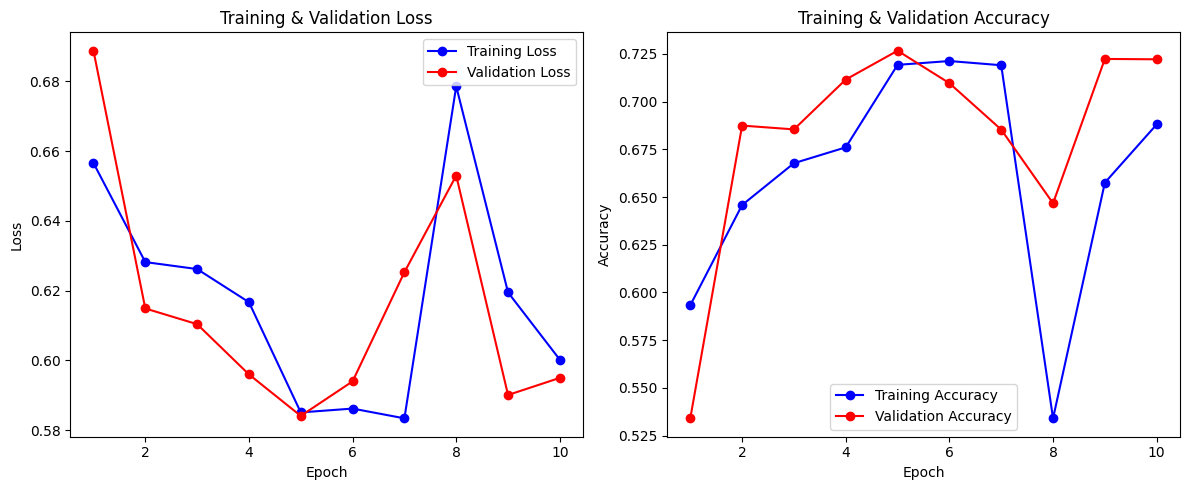

In [ ]:
import matplotlib.pyplot as plt
epochs = range(1, 11)

plt.figure(figsize=(12, 5))
train_losses = [0.6566, 0.6282, 0.6262, 0.6167, 0.5851, 0.5862, 0.5834, 0.6786, 0.6195, 0.6002]
val_losses = [0.6888, 0.6149, 0.6104, 0.5960, 0.5841, 0.5940, 0.6253, 0.6530, 0.5901, 0.5950]
train_accuracies = [0.5933, 0.6458, 0.6677, 0.6760, 0.7192, 0.7212, 0.7190, 0.5341, 0.6575, 0.6880]
val_accuracies = [0.5341, 0.6874, 0.6854, 0.7115, 0.7266, 0.7096, 0.6853, 0.6467, 0.7223, 0.7221]

#loss
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, 'b-o', label='Training Loss')
plt.plot(epochs, val_losses, 'r-o', label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training & Validation Loss')
plt.legend()

#accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, 'b-o', label='Training Accuracy')
plt.plot(epochs, val_accuracies, 'r-o', label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training & Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


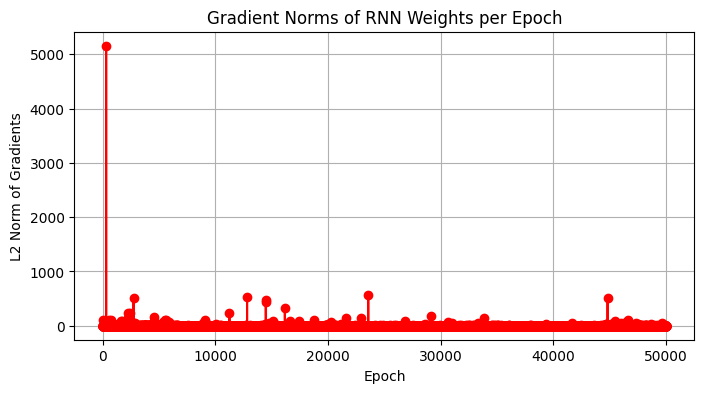

In [47]:
plt.figure(figsize=(8, 4))
plt.plot(range(1, len(gradient_norms) + 1), gradient_norms, marker='o', color='red')
plt.title('Gradient Norms of RNN Weights per Epoch')
plt.xlabel('Epoch')
plt.ylabel('L2 Norm of Gradients')
plt.grid(True)
plt.show()


In [48]:
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for batch_inputs, batch_labels in val_loader:
        batch_inputs = batch_inputs.to(device)
        outputs = model(batch_inputs)
        all_preds.extend(outputs.cpu().numpy())
        all_labels.extend(batch_labels.numpy())

predicted = [1 if p >= 0.5 else 0 for p in all_preds]

print("Accuracy:", accuracy_score(all_labels, predicted))
print("F1 Score:", f1_score(all_labels, predicted))
print("Classification Report:\n", classification_report(all_labels, predicted))


Accuracy: 0.7221125
F1 Score: 0.6995201730080421
Classification Report:
               precision    recall  f1-score   support

         0.0       0.69      0.80      0.74     80000
         1.0       0.76      0.65      0.70     80000

    accuracy                           0.72    160000
   macro avg       0.73      0.72      0.72    160000
weighted avg       0.73      0.72      0.72    160000

